In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import pickle as pkl
import math
import glob
import os
from collections import defaultdict

from sklearn.preprocessing import minmax_scale

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.lines import Line2D

In [2]:
path_data='/om2/user/khrovati/data/cross_system_integration/'
path_names=path_data+'names_parsed/'
path_fig=path_data+'figures/'

Here NMI fixed is used as NMI_OPT is confounded by batch effects - i.e. low either if ct is split up due to batches or if mixing with other cts.

In [3]:
# Names
model_map=pkl.load(open(path_names+'models.pkl','rb'))
param_map=pkl.load(open(path_names+'params.pkl','rb'))
metric_map=pkl.load(open(path_names+'metrics.pkl','rb'))
# Here NMI fixed is used
metric_map=dict([(k,v) if k!='nmi_opt' else ('nmi','NMI fixed') for k,v in metric_map.items() ])
dataset_map=pkl.load(open(path_names+'datasets.pkl','rb'))
metric_meaning_map=pkl.load(open(path_names+'metric_meanings.pkl','rb'))
metric_meaning_map['nmi']=metric_meaning_map['nmi_opt']
metric_map_rev=dict(zip(metric_map.values(),metric_map.keys()))
dataset_map_rev=dict(zip(dataset_map.values(),dataset_map.keys()))
system_map=pkl.load(open(path_names+'systems.pkl','rb'))
params_opt_map=pkl.load(open(path_names+'params_opt_model.pkl','rb'))
params_opt_gene_map=pkl.load(open(path_names+'params_opt_genes.pkl','rb'))
param_opt_vals=pkl.load(open(path_names+'optimized_parameter_values.pkl','rb'))
cell_type_map=pkl.load(open(path_names+'cell_types.pkl','rb'))

# cmap
model_cmap=pkl.load(open(path_names+'model_cmap.pkl','rb'))
obs_col_cmap=pkl.load(open(path_names+'obs_col_cmap.pkl','rb'))
metric_background_cmap=pkl.load(open(path_names+'metric_background_cmap.pkl','rb'))
metric_background_cmap['nmi']=metric_background_cmap['nmi_opt']

## Performance

In [4]:
# Load data and keep relevant runs
ress=[]
for dataset,dataset_name in dataset_map.items():
    print(dataset_name)
    path_integration=f'{path_data}eval/{dataset}/integration/'
    res=[]
    for run in glob.glob(path_integration+'*/'):
        if os.path.exists(run+'args.pkl') and \
            os.path.exists(run+'scib_metrics.pkl') and \
            os.path.exists(run+'scib_metrics_scaled.pkl'):
            args=pd.Series(vars(pkl.load(open(run+'args.pkl','rb'))))
            if args.params_opt in ['kl_weight','z_distance_cycle_weight_std']:
                metrics=pd.Series(pkl.load(open(run+'scib_metrics.pkl','rb')))
                data=pd.concat([args,metrics])        
                metrics_scl=pd.Series(pkl.load(open(run+'scib_metrics_scaled.pkl','rb')))
                metrics_scl.index=metrics_scl.index.map(lambda x: x+'_scaled')
                data=pd.concat([args,metrics,metrics_scl])            
                name=run.split('/')[-2]
                data.name=name
                res.append(data)
    res=pd.concat(res,axis=1).T

    # Parse res table

    # Parse params
    res['param_opt_col']=res.params_opt.replace(
        {
         'z_distance_cycle_weight_std':'z_distance_cycle_weight',})
    res['param_opt_val']=res.apply(
        lambda x: x[x['param_opt_col']] if x['param_opt_col'] is not None else 0,axis=1)
    # param opt val for plotting - converted to str categ below
    res['param_opt_val_str']=res.apply(
        lambda x: x[x['param_opt_col']] if x['param_opt_col'] is not None else np.nan,axis=1)
    
    res['params_opt']=pd.Categorical(res['params_opt'],sorted(res['params_opt'].unique()), True)

    # Keep relevant params and name model
    params_opt_vals=set(params_opt_map.keys())
    res_sub=res.query('params_opt in @params_opt_vals').copy()
    res_sub['model']=res_sub.params_opt.replace(params_opt_map).astype(str)   
    # Models present in data but have no params opt
    nonopt_models=list(
        (set(params_opt_map.values()) & set(res_sub['model'].unique()))-set(
        [model for models,params_vals in param_opt_vals for model in models]))
    # Query: model not opt OR model belongs to one of the models that have opt params
    # and if given param is opt then it is within list of param values
    res_query=[f'model in {nonopt_models}']
    # Models with opt params
    for models,params_vals in param_opt_vals:
        res_query_sub=[]
        # Param value in vals if param was optimised
        for param,vals in params_vals:
            # For param check if it was opt in data as else there will be no col for it
            if param in res_sub.columns:
                res_query_sub.append(f'({param} in {vals} & "{param}"==param_opt_col)')
        # Only add to query models for which any param was opt
        if len(res_query_sub)>0:
            res_query_sub='(('+' | '.join(res_query_sub)+f') & model in {models})'
            res_query.append(res_query_sub)
    res_query=' | '.join(res_query)
    #print(res_query)
    res_sub=res_sub.query(res_query).copy()

    # Add pretty model names
    res_sub['model_parsed']=pd.Categorical(
        values=res_sub['model'].map(model_map),
        # Custom ordering here to have cVAE first
        categories=[model_map['cVAE'],model_map['cycle']], 
        ordered=True)
    # Add prety param names
    res_sub['param_parsed']=pd.Categorical(
        values=res_sub['param_opt_col'].map(param_map),
        categories=param_map.values(), ordered=True)
    # Add gene names
    res_sub['genes_parsed']=pd.Categorical(
        values=res_sub['params_opt'].map(params_opt_gene_map),
         categories=list(dict.fromkeys(params_opt_gene_map.values())), ordered=True)
    
    display(res_sub.groupby(['model_parsed','param_parsed','genes_parsed'],observed=True).size())
    
    # Store
    res_sub['dataset_parsed']=dataset_name
    ress.append(res_sub)
    
ress=pd.concat(ress)
ress['dataset_parsed']=pd.Categorical(
    values=ress['dataset_parsed'],
    categories=list(dataset_map.values()), ordered=True)

# plotting param vals
ress['param_opt_val_str']=pd.Categorical(
    values=ress['param_opt_val_str'].fillna('none').astype(str),
    categories=[str(i) for i in 
                sorted([i for i in ress['param_opt_val_str'].unique() if not np.isnan(i)])
               ]+['none'],
    ordered=True)

Mouse-Human


model_parsed  param_parsed  genes_parsed
cVAE          KL LW         OTO             12
CYC           Cycle LW      OTO             12
dtype: int64

Organoid-Tissue


model_parsed  param_parsed  genes_parsed
cVAE          KL LW         OTO             12
CYC           Cycle LW      OTO             12
dtype: int64

Cell-Nuclei


model_parsed  param_parsed  genes_parsed
cVAE          KL LW         OTO             12
CYC           Cycle LW      OTO             12
dtype: int64

/tmp/ipykernel_24970/187471552.py:85: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  ress=pd.concat(ress)


In [5]:
ress.groupby(['dataset_parsed','model_parsed','param_parsed','genes_parsed'],observed=True).size()

dataset_parsed   model_parsed  param_parsed  genes_parsed
Mouse-Human      cVAE          KL LW         OTO             12
                 CYC           Cycle LW      OTO             12
Organoid-Tissue  cVAE          KL LW         OTO             12
                 CYC           Cycle LW      OTO             12
Cell-Nuclei      cVAE          KL LW         OTO             12
                 CYC           Cycle LW      OTO             12
dtype: int64

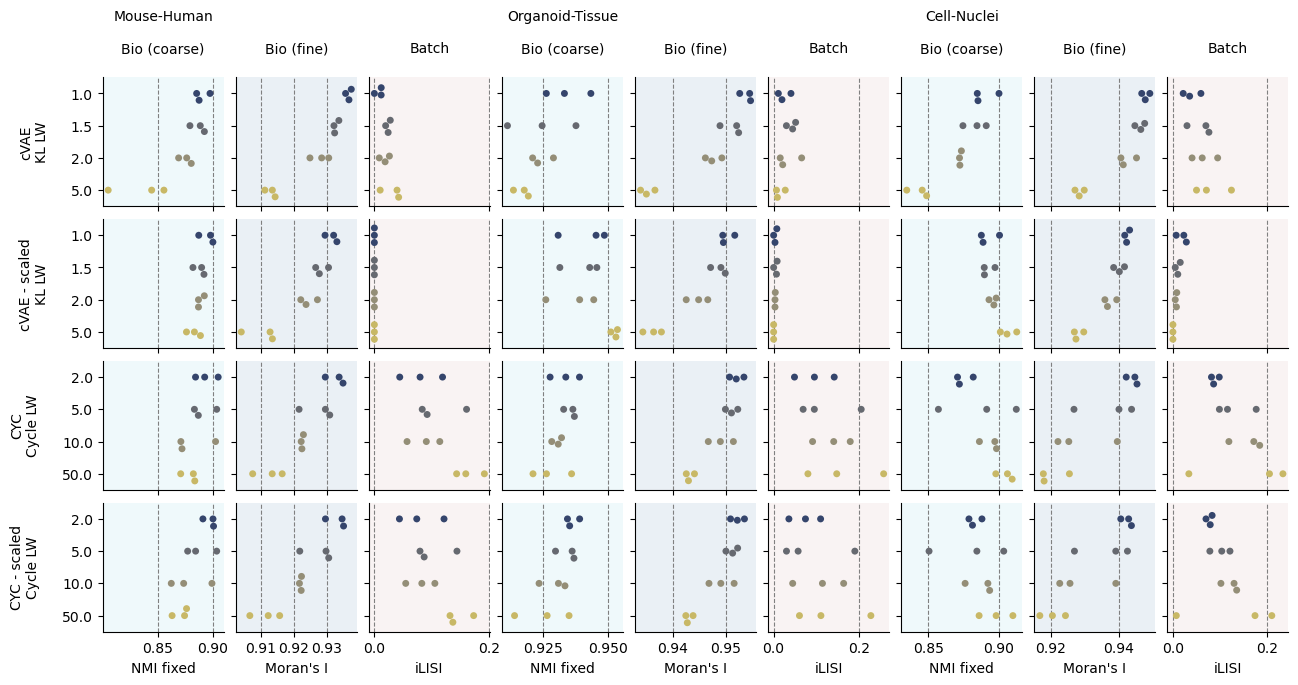

In [6]:
params=ress.groupby(['model_parsed','param_parsed','genes_parsed'],observed=True,sort=True
            ).size().index.to_frame().reset_index(drop=True)
nrow=params.shape[0]*2
n_metrics=len(metric_map)
ncol=ress['dataset_parsed'].nunique()*n_metrics
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*1.7,nrow*1.8),sharex='col',sharey='row')
for icol_ds, (dataset_name,res_ds) in enumerate(ress.groupby('dataset_parsed')):
    
    # Max row for ds
    models_parsed_ds=set(res_ds.model_parsed)
    params_parsed_ds=set(res_ds.param_parsed)
    genes_parsed_ds=set(res_ds.genes_parsed)
    irow_max_ds=max([irow for irow,(model_parsed,param_parsed,genes_parsed) in params.iterrows() if 
     model_parsed in models_parsed_ds and 
     param_parsed in params_parsed_ds and
     genes_parsed in genes_parsed_ds])*2+1
    
    for icol_metric,(metric,metric_name) in enumerate(metric_map.items()):
        icol=icol_ds*n_metrics+icol_metric
        for irow_param,(_,param_data) in enumerate(params.iterrows()):
            res_sub=res_ds.query(
                f'model_parsed=="{param_data.model_parsed}" & '+\
                f'param_parsed=="{param_data.param_parsed}" & '+\
                f'genes_parsed=="{param_data.genes_parsed}"')
            if res_sub.shape[0]>0:
                res_sub=res_sub.copy()
                res_sub['param_opt_val_str']=\
                    res_sub['param_opt_val_str'].cat.remove_unused_categories()
                for irow_scl,scaling in enumerate([False,True]):
                    irow=irow_param*2+irow_scl
                    ax=axs[irow,icol]
                    sb.swarmplot(x=metric if not scaling else metric+'_scaled',
                                 y='param_opt_val_str',data=res_sub,ax=ax, 
                                hue='param_opt_val_str',palette='cividis')
                    ax.set(facecolor = metric_background_cmap[metric])
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    ax.grid(axis='x', linestyle='--', color='gray')
                    ax.get_legend().remove()
                    if irow!=irow_max_ds:
                        ax.set_xlabel('')
                    else:
                        # Add xaxis
                        # Must turn label to visible as sb will set it off if sharex
                        # Must reset ticks as will be of due to sharex
                        ax.set_xlabel(metric_name,visible=True)
                        #ax.xaxis.set_label_position('bottom') 
                        ax.xaxis.set_ticks_position('bottom')
                    if irow==0:
                        title=''
                        if icol%3==0:
                            title=title+dataset_name+'\n\n'
                        ax.set_title(title+metric_meaning_map[metric]+'\n',fontsize=10)
                    if icol==0:
                        ax.set_ylabel(
                            param_data.model_parsed+(' - scaled' if scaling else '')+'\n'+\
                            param_data.param_parsed+'\n')
                    else:
                        ax.set_ylabel('')
            else:
                ax.remove()
            

plt.subplots_adjust( wspace=0.1,hspace=0.1)
fig.set(facecolor = (0,0,0,0))
# Turn off tight layout as it messes up spacing if adding xlabels on intermediate plots
#fig.tight_layout()

plt.savefig(path_fig+'scaling_embed-score_all-swarm.pdf',
            dpi=300,bbox_inches='tight')
plt.savefig(path_fig+'scaling_embed-score_all-swarm.png',
            dpi=300,bbox_inches='tight')

### Simplified plot of only cVAE on the pancreas dataset

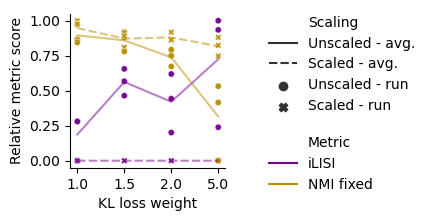

In [7]:
# Make plotting df with scaled/unscaled embed metrics
res_plot=ress.query(f'dataset_parsed=="{dataset_map["pancreas_conditions_MIA_HPAP2"]}" & model_parsed=="{model_map["cVAE"]}"').copy()
res_sub=res_plot[['nmi','ilisi_system','param_opt_val','model_parsed']].copy()
scaling_col='Scaled'
res_sub[scaling_col]='no'
res_sub_scaled=res_plot[['nmi_scaled','ilisi_system_scaled','param_opt_val','model_parsed']].rename(
    {'nmi_scaled':'nmi','ilisi_system_scaled':'ilisi_system'},axis=1)
res_sub_scaled[scaling_col]='yes'
res_plot=pd.concat([res_sub,res_sub_scaled])
param_opt_val_col=param_map['kl_weight']
# Make categorical for coloring
res_plot['model_parsed']=res_plot['model_parsed'].cat.remove_unused_categories()
res_plot[param_opt_val_col]=pd.Categorical(
    res_plot['param_opt_val'].astype(str),
    [str(i) for i in sorted(res_plot['param_opt_val'].unique())], True)
res_plot['ilisi_system']=minmax_scale(res_plot['ilisi_system'])
res_plot['nmi']=minmax_scale(res_plot['nmi'])
# Compute mean scores
res_plot_me=res_plot.groupby(['model_parsed',scaling_col,param_opt_val_col]
                            )[['nmi','ilisi_system']].mean().reset_index()
# Shuffle points as else some param_opt_vals are on top
res_plot=res_plot.loc[np.random.RandomState(seed=0).permutation(res_plot.index),:]
res_plot[scaling_col]=res_plot[scaling_col].replace({'yes':'Scaled - run','no':'Unscaled - run'})
res_plot_me[scaling_col]=res_plot_me[scaling_col].replace({'yes':'Scaled - avg.','no':'Unscaled - avg.'})
# Plot
fig,ax=plt.subplots(figsize=(2,2))
palette_metric={'ilisi_system':'#74028E','nmi':'#B78E00'}
s_run=20
sb.lineplot(x=param_opt_val_col,y='ilisi_system',style=scaling_col,data=res_plot_me,ax=ax,
           c=palette_metric['ilisi_system'],alpha=0.5)
sb.scatterplot(x=param_opt_val_col,y='ilisi_system',style=scaling_col,data=res_plot,ax=ax,
           c=palette_metric['ilisi_system'],s=s_run,alpha=0.8)
# Get legend elements before they are repeated due to the other metric
handles,labels=ax.get_legend_handles_labels()
sb.lineplot(x=param_opt_val_col,y='nmi',style=scaling_col,data=res_plot_me,ax=ax,
           c=palette_metric['nmi'],alpha=0.5)
sb.scatterplot(x=param_opt_val_col,y='nmi',style=scaling_col,data=res_plot,ax=ax,
           c=palette_metric['nmi'],s=s_run,alpha=0.8)
ax.set_ylabel('Relative metric score')
ax.set_xlabel(param_opt_val_col.replace('LW','loss weight'))
ax.set(facecolor = (0,0,0,0))
fig.set_facecolor((0,0,0,0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add to legen metric colors
handles=[Line2D([0], [0],  markersize=0, lw=0, markeredgewidth=0)]+handles+\
        [Line2D([0], [0],  markersize=0, lw=0, markeredgewidth=0),
         Line2D([0], [0], color=palette_metric['ilisi_system']),
         Line2D([0], [0], color=palette_metric['nmi'])]
labels=['Scaling']+labels+['\nMetric',metric_map['ilisi_system'],metric_map['nmi']]

ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.2,1.07),frameon=False)

plt.savefig(path_fig+'scaling_embed-score_pancreas_cVAE_2d-line.pdf',
            dpi=300,bbox_inches='tight')
plt.savefig(path_fig+'scaling_embed-score_pancreas_cVAE_2d-line.png',
            dpi=300,bbox_inches='tight')

## Embedding

In [8]:
# seed=1
ress_sub=ress.query('seed==1')

In [9]:
# Load embeds where seed=1
embeds=dict()
for run,run_data in ress_sub.iterrows():
    path_run=f'{path_data}eval/{dataset_map_rev[run_data["dataset_parsed"]]}/integration/{run}/'
    embeds[run]=sc.read(path_run+'embed.h5ad')

### Dimension span

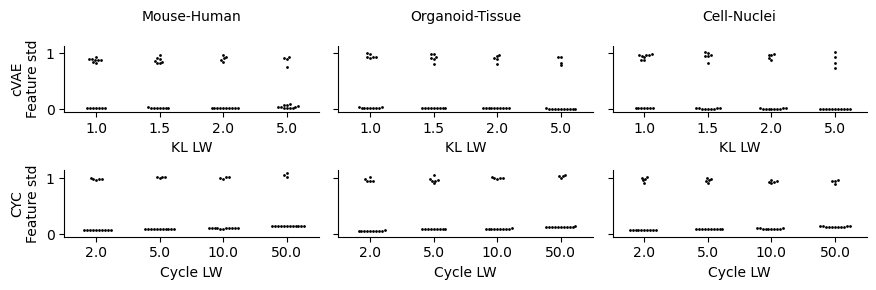

In [10]:
# Dimension std swarm
params=ress_sub.groupby(['model_parsed','param_parsed','genes_parsed'],observed=True,sort=True
            ).size().index.to_frame().reset_index(drop=True)
nrow=params.shape[0]
ncol=ress_sub['dataset_parsed'].nunique()
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*3,nrow*1.5),sharex=False,sharey=True)
for icol, (dataset_name,res_ds) in enumerate(ress_sub.groupby('dataset_parsed')):
    for irow,(_,param_data) in enumerate(params.iterrows()):
        res_sub=res_ds.query(
                f'model_parsed=="{param_data.model_parsed}" & '+\
                f'param_parsed=="{param_data.param_parsed}" & '+\
                f'genes_parsed=="{param_data.genes_parsed}"')
        res_sub=res_sub.copy()
        res_sub['param_opt_val_str']=\
            res_sub['param_opt_val_str'].cat.remove_unused_categories()
        
        # Data for plotting
        # Dimensions ordered by std
        plot=[]
        for run,param_val in res_sub['param_opt_val_str'].items():
            embed=embeds[run]
            stds=embed.X.std(axis=0)
            dims=np.argsort(stds)[::-1]
            for idim,dim in enumerate(dims):
                plot.append({
                    'feature':idim+1,
                    param_data.param_parsed:param_val,
                    'std':stds[dim]
                })
        plot=pd.DataFrame(plot)
        plot['feature']=pd.Categorical(
            values=plot['feature'].astype(str),
            categories=[str(i) for i in sorted(plot['feature'].unique())],
            ordered=True)
        plot[param_data.param_parsed]=pd.Categorical(
            values=plot[param_data.param_parsed],
            categories=res_sub['param_opt_val_str'].cat.categories,
            ordered=True)
        
        # Plot
        ax=axs[irow,icol]        
        sb.swarmplot(x=param_data.param_parsed,y='std',data=plot, ax=ax,s=2,
                     c='k',linewidth=0)
        
        # Make pretty
        ax.set(facecolor = (0,0,0,0))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if icol==0:                        
            ax.set_ylabel(param_data.model_parsed+'\nFeature std')
        else:
            ax.set_ylabel('',visible=False)
        if irow==0:
            ax.set_title(dataset_name+'\n',fontsize=10)

fig.set(facecolor = (0,0,0,0))
fig.tight_layout()

plt.savefig(path_fig+'scaling_embed-dimension_stds-swarm.pdf',
            dpi=300,bbox_inches='tight')
plt.savefig(path_fig+'scaling_embed-dimension_stds-swarm.png',
            dpi=300,bbox_inches='tight')

### UMAP
UMAPs for min and max param with seed=0 shown for scaled and unscaled

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data f

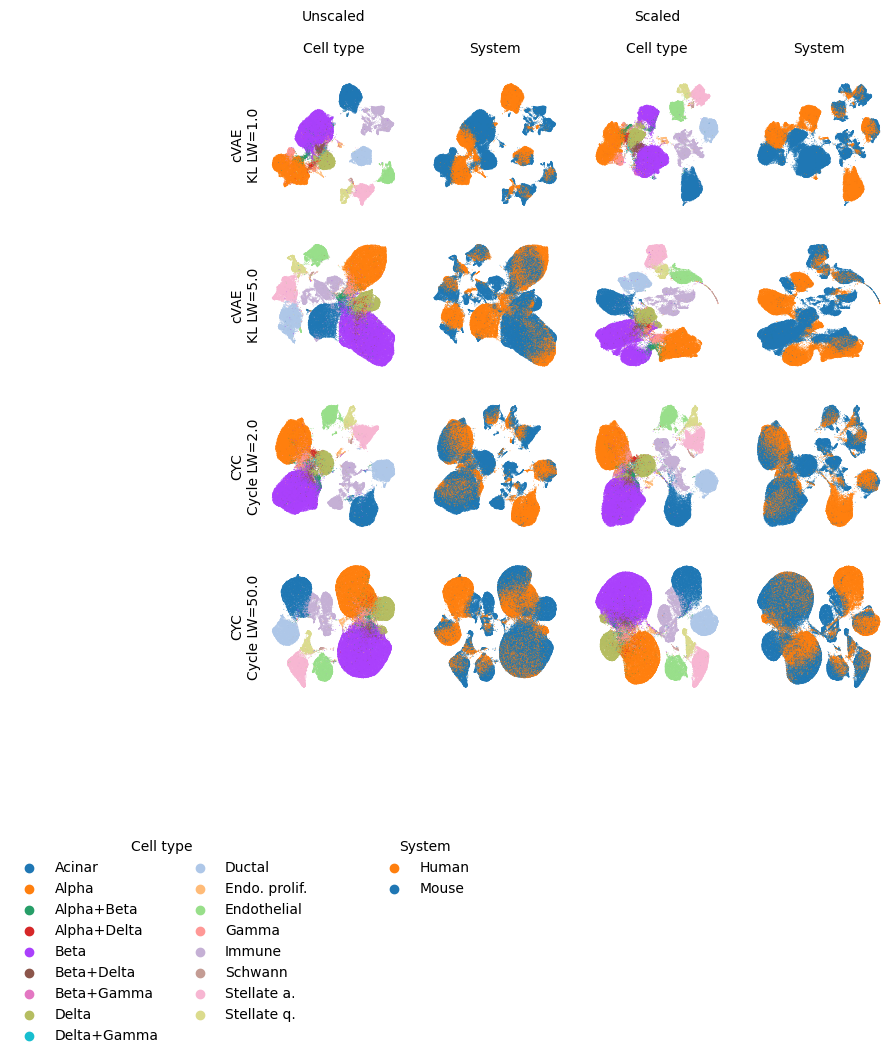

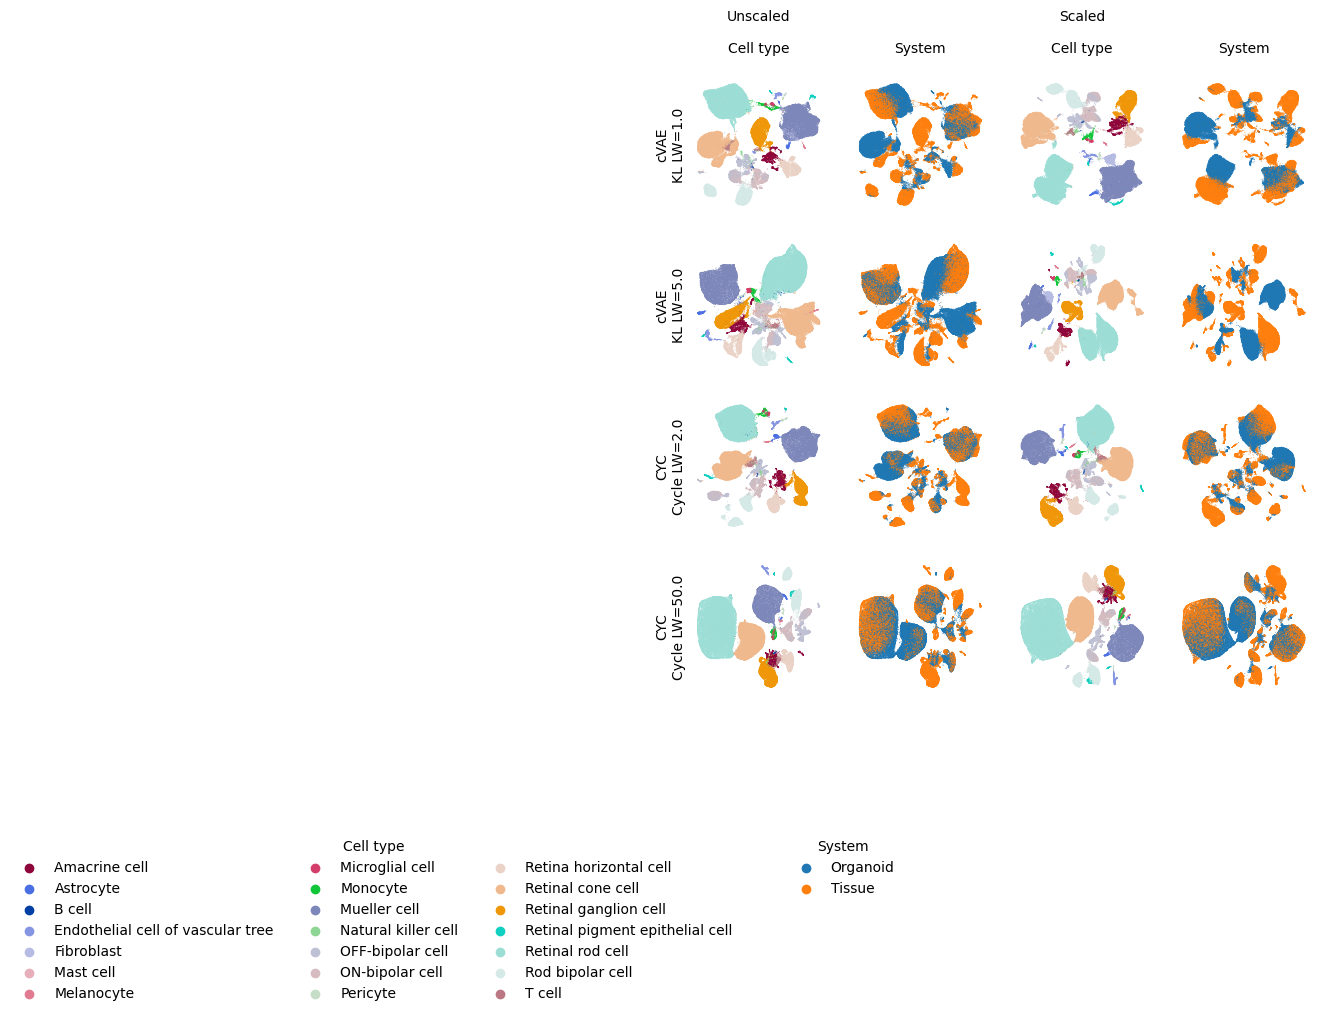

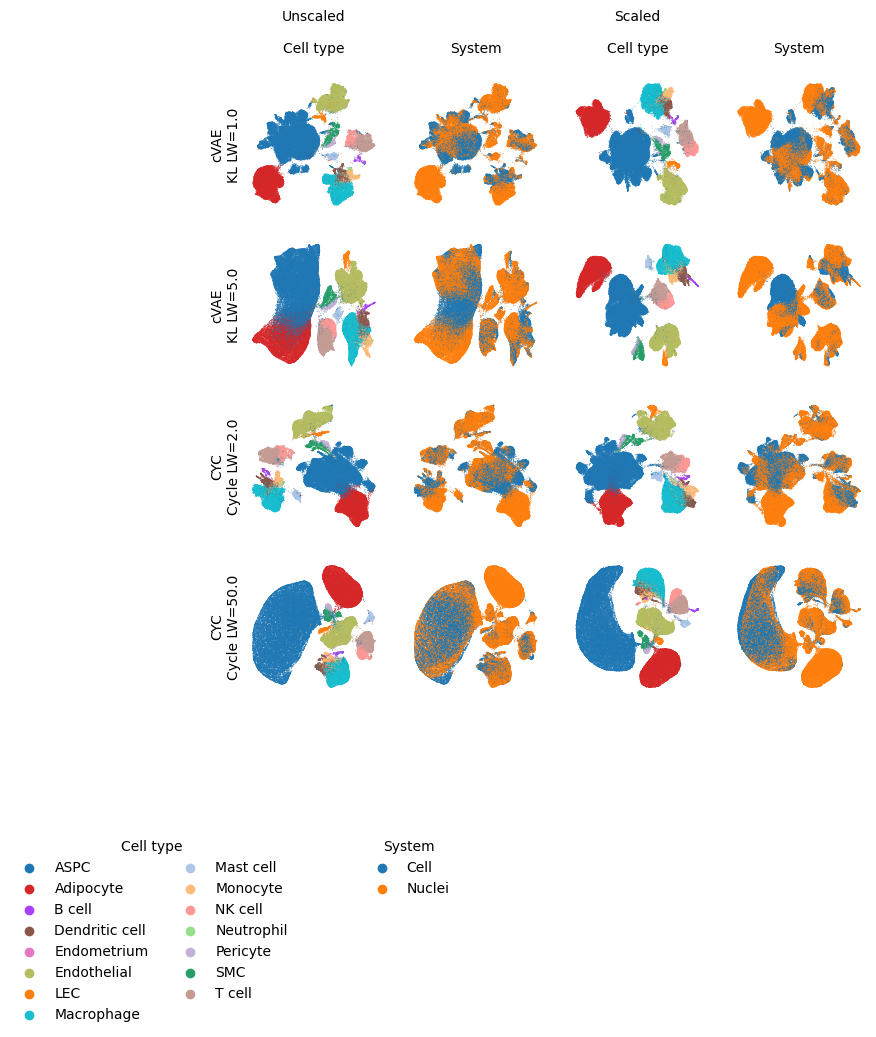

In [11]:
# UMAPs of scaled and unscaled
# Select runs - min and max param val
params=ress_sub.groupby(['dataset_parsed','model_parsed','param_parsed'],observed=True
                ).apply(
    lambda x: pd.DataFrame({
        'edge':['min','max'],
        'param_opt_val':[x['param_opt_val'].min(),x['param_opt_val'].max()],
        'run':[x['param_opt_val'].idxmin(),x['param_opt_val'].idxmax()],
        'group_key':[x['group_key'][0]]*2,
        'system_key':[x['system_key'][0]]*2,
        })).reset_index()
ct_col_name='Cell type'
sys_col_name='System'
for dataset_name,params_sub in params.groupby('dataset_parsed'):
    dataset=dataset_map_rev[dataset_name]
    nrow=params_sub.shape[0]
    ncol=4
    fig,axs=plt.subplots(nrow,ncol,figsize=(2*ncol,2*nrow))       
    for irow,(_,res_sub) in enumerate(params_sub.iterrows()):
        for icol_scl,scaling in enumerate([False,True]):
            for icol_col,(col_name,col) in enumerate(zip(
                [ct_col_name,sys_col_name],
                [res_sub.group_key,res_sub.system_key])):
                icol=icol_scl*2+icol_col
                embed=embeds[res_sub['run']]
                    
                # Set cmap and col val names
                cmap=obs_col_cmap[dataset_map_rev[dataset_name]][col]
                if col_name==sys_col_name:
                    # Map system to str as done in integrated embeds but not in non-int
                    embed.obs[col+'_parsed']=embed.obs[col].astype(str).map(system_map[dataset])
                    cmap={system_map[dataset][k]:v for k,v in cmap.items()}
                elif col_name==ct_col_name:
                    # Map system to str as done in integrated embeds but not in non-int
                    embed.obs[col+'_parsed']=embed.obs[col].astype(str).map(cell_type_map[dataset])
                    cmap={cell_type_map[dataset][k]:v for k,v in cmap.items()}

                # Plot
                ax=axs[irow,icol]
                sc.pl.embedding(embed,'X_umap'+('_scaled' if scaling else ''),
                                color=col+'_parsed',ax=ax,show=False,
                                palette=cmap, frameon=False,title='')

                # Make pretty
                if irow==0:
                    if icol%2==0:
                        title=('Unscaled' if not scaling else 'Scaled')+'\n\n'
                    else:
                        title=''
                            
                    title=title+col_name+'\n'
                    ax.set_title(title,fontsize=10)

                if icol==0:
                    ax.axis('on')
                    ax.tick_params(
                            top='off', bottom='off', left='off', right='off', 
                            labelleft='on', labelbottom='off')
                    ax.set_ylabel(
                        f'{res_sub.model_parsed}\n{res_sub.param_parsed}={res_sub.param_opt_val}',
                        rotation=90)
                    ax.set_xlabel('')
                    ax.set(frame_on=False)

                if irow!=(nrow-1) or icol>1:
                    ax.get_legend().remove()
                else:
                    ax.legend(bbox_to_anchor=(0.4,-1),frameon=False,title=col_name,
                              ncol=math.ceil(embed.obs[col].nunique()/10))

    fig.set(facecolor = (0,0,0,0))
    plt.savefig(path_fig+f'scaling_embed-embed_{dataset}_scl_minmax-umap.pdf',
                dpi=300,bbox_inches='tight')
    plt.savefig(path_fig+f'scaling_embed-embed_{dataset}_scl_minmax-umap.png',
                dpi=300,bbox_inches='tight')